# Generating Cat Images With DCGAN Architecture
## Vision:
It is the purpose of this project to explore the generative power of GAN architecture and investigate how GAN architecture can create new images given prior example images. Specifically, the vision of this project is to end up with a generator trained with GAN architecture which can generate realistic, unique, and varied cat photos.

## Background:
GAN (generative adversarial network) is a type of machine learning architecture which
combines together two neural networks: a discriminator (a standard image labeler convolutional
network which labels images as fake or real) and a generator (a network which creates images from random noise). These two networks are 
combined together into a one model and train against each other with the generator attempting to fool the discriminator into applying wrong labels and the discriminator attempting to correctly label each image. The standard structure of DCGAN architecture generally comes from a paper shown at ICLR 2016 written by Alec Radford, Luke Metz, and Soumith Chintala (found here: https://arxiv.org/pdf/1511.06434.pdf). This paper established many of the base guidelines by which DCGANs are now created. A DCGAN adds to the original GAN concept by giving a standard structure which can result in a good GAN model through the use of many deconvolutional layers in the generator to increase the size of a randomly generated tiny image to the desired size. Deconvolutional layers (more accurately called transposed covolutional layers) take nearly identical parameters as their convolutional layer counterpart but have the ablility to upscale an image while also at the same time employing convolution to fill in the new created pixels using learned weights.

## Implementation:
For my implimentation, I worked off of a guide (found here:https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) which built a GAN to generate images from the cifar-10 dataset. While the Machine Learning Mastery guide for a CIFAR10 GAN used 32 x 32 color photographs, 
to create slightly higher resolution photos and to extend the system, my architecture was made to use and output 64 x 64 photos instead. This required making adjustments to both the generator and discriminator in order to get correct output.
All data used to train the GANs in this report were taken form this kaggle cat faces dataset, https://www.kaggle.com/spandan2/cats-faces-64x64-for-generative-models


In [77]:
#@title Set up for google colab, import needed modules, and define a way to load data
from os import listdir
import sys, subprocess
from matplotlib import pyplot
import math
from keras.layers import Input, Dense, Reshape, Flatten, Dropout 
from keras.layers import BatchNormalization, Activation, ZeroPadding2D 
from keras.layers.advanced_activations import LeakyReLU 
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model 
from keras.models import load_model
from keras.optimizers import Adam,SGD 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.backend import clear_session
from numpy import asarray
from numpy import save
from numpy import load
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint

# install tensorflow gpu build if in colab
# taken from https://timsainburg.com/google%20colab.html
def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())
        
import sys, subprocess
IN_COLAB = "google.colab" in sys.modules
colab_requirements = ["pip install tf-nightly-gpu-2.0-preview"]
if IN_COLAB:
    for i in colab_requirements:
        run_subprocess_command(i)
    from google.colab import drive
    drive.mount('/content/drive')

# define a way to load data
def load_data(convert,path):
  if(convert==True):
    #Load in photos from google drive
    #define location of dataset
    folder = path
    photos = list()
    progress = 0
    #load each image in directory
    for file in listdir(folder):
      if (progress%100)==0:
        print(progress)
      #load image
      photo = load_img(folder + file, target_size=(image_width, image_height))
      #convert to numpy array
      photo = img_to_array(photo)
      #store
      photos.append(photo)
      progress = progress+1
    #convert to a numpy array
    photos = asarray(photos)
    print(photos.shape)
    #save the reshaped photos
    save('saved_data.npy', photos)
    return photos
  else:
    # load photos from pre-made npy file
    photos = load(path)
    return photos

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Due to the size of this dataset, converting the images to a numpy array each time it is run would take too much time. To help with this, if convertFolder is set to True the load_data function will convert a folder of images to a numpy array and save it. Else, if convertFolder is set to false, a previously created numpy array file will be loaded in from the path.


In [0]:
#Define variables
image_width = 64
image_height = 64
path = '/content/drive/My Drive/cs/cs344/cat_64x64.npy'
convertFolder = False
#Defining the Input shape 
image_shape = (64, 64, 3)    
latent_dim = 100
#load in cat data
X = load_data(convertFolder,path)

Displaying some of the images from the dataset demonstrates the images were loaded correctly.

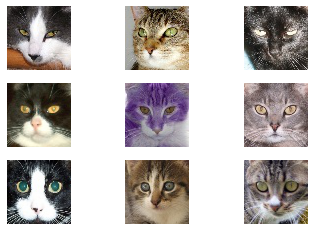

In [79]:
#display some images to test
for i in range(9):
	# define subplot
	pyplot.subplot(3, 3, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[randint(0, len(X))] / 255.0)
# show the figure
pyplot.show()
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [-1,1]
X = (X - 127.5) / 127.5

Next, the discriminator is defined. For both my discriminator and generator, I generally followed the standard structure DCGANs are generally supposed to have with a few alterations. My discriminator  follows standard practice of having a LeakyReLU activation layer after each convolutional layer. This Allows for some negative value flow which is supposed to improve performance. Differing from the standard structure, though, I found that I received the best performance when not increasing the number of filters in each layer. I did still follow DCGAN guidelines in gradually increasing the amount of filters over time, just not in every layer. Furthermore, I found that using a dropout layer after the flatten layer did improve my performance. Other than this, every other element in the model including optimizer is taken from the DCGAN paper.

In [80]:
# define discriminator model
def define_discriminator(in_shape=(64,64,3)):
    model = Sequential()
    # perform convolution on initial size
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 32x32
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 16x16
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 8x8
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 4x4
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
# create the discriminator
d_model = define_discriminator()
d_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 256)        

For my generator I start with a 4x4 image and upsample it to the required 64x64 image through Conv2DTranspose layers. During my testing, I found that I could get the most consistent results by using ReLU activation (instead of leakyReLU which is occasionally used for the generator as well). Differently from the Machine Learning Mastery Cifar-10 GAN guide, my generator was built closer in structure to the more traditional DCGAN, by gradually decreasing the number of filters (the guide employs the same number of filters in each Conv2DTranspose layer).

In [81]:
# define generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 16x16
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 32x32
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # upsample to 64x64
    model.add(Conv2DTranspose(32, (4,4), strides=(2,2), padding='same'))
    model.add(Activation("relu")) 
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
activation_5 (Activation)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        131136    
_________________________________________________________________
activation_6 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)       

The discrimantor and generator are then put together into one model with the generator first. Importantly, the discrimator is made to be untrainable in this this model and needs to be trained seperately on its own during training. If the discrimantor is not made untrainable, it is possible that the generator can learn to directly manipulate the discriminator's weights during this training through its outputs. By training the discriminator seperately, this possibility is much lessened.

In [82]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 64, 64, 3)         1119331   
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1112577   
Total params: 2,231,908
Trainable params: 1,119,331
Non-trainable params: 1,112,577
_________________________________________________________________


In [0]:
#@title Add auxiliary helping functions
# get real samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate fake samples 
# also add labels indicating their fakeness
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# plot generated images
def display_images(examples, n=3):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    pyplot.show() 
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    display_images(x_fake)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

The discriminator and generator are then trained. First the discriminator is trained on the real dataset, then on the fake dataset, and finally the generator is trained through the combined GAN. The performance of the discriminator and generator are evaluated every 10 epochs and a sample of pictures from the generator are displayed.

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/123, d1=0.695, d2=0.696 g=0.692
>1, 2/123, d1=0.594, d2=0.696 g=0.692
>1, 3/123, d1=0.479, d2=0.698 g=0.691
>1, 4/123, d1=0.283, d2=0.700 g=0.691
>1, 5/123, d1=0.107, d2=0.701 g=0.694
>1, 6/123, d1=0.057, d2=0.700 g=0.698
>1, 7/123, d1=0.015, d2=0.694 g=0.706
>1, 8/123, d1=0.016, d2=0.681 g=0.721
>1, 9/123, d1=0.008, d2=0.663 g=0.751
>1, 10/123, d1=0.010, d2=0.628 g=0.811
>1, 11/123, d1=0.012, d2=0.579 g=0.902
>1, 12/123, d1=0.008, d2=0.515 g=1.032
>1, 13/123, d1=0.016, d2=0.440 g=1.207
>1, 14/123, d1=0.001, d2=0.342 g=1.519
>1, 15/123, d1=0.004, d2=0.227 g=2.028
>1, 16/123, d1=0.001, d2=0.125 g=2.686
>1, 17/123, d1=0.004, d2=0.058 g=3.387
>1, 18/123, d1=0.000, d2=0.031 g=3.930
>1, 19/123, d1=0.000, d2=0.022 g=4.254
>1, 20/123, d1=0.000, d2=0.026 g=4.341
>1, 21/123, d1=0.000, d2=0.044 g=4.735
>1, 22/123, d1=0.000, d2=0.030 g=5.862
>1, 23/123, d1=0.000, d2=0.004 g=7.004
>1, 24/123, d1=0.000, d2=0.003 g=7.554
>1, 25/123, d1=0.000, d2=0.002 g=8.309
>1, 26/123, d1=0.000, d2=0.001 g=8

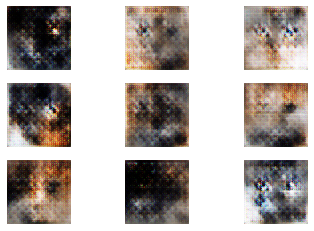

>11, 1/123, d1=0.524, d2=0.697 g=1.198
>11, 2/123, d1=0.536, d2=0.636 g=1.263
>11, 3/123, d1=0.568, d2=0.575 g=1.279
>11, 4/123, d1=0.611, d2=0.631 g=1.422
>11, 5/123, d1=0.491, d2=0.490 g=1.327
>11, 6/123, d1=0.624, d2=0.588 g=1.208
>11, 7/123, d1=0.561, d2=0.686 g=1.119
>11, 8/123, d1=0.540, d2=0.543 g=1.202
>11, 9/123, d1=0.496, d2=0.535 g=1.362
>11, 10/123, d1=0.471, d2=0.406 g=1.396
>11, 11/123, d1=0.536, d2=0.508 g=1.351
>11, 12/123, d1=0.506, d2=0.679 g=1.336
>11, 13/123, d1=0.469, d2=0.552 g=1.368
>11, 14/123, d1=0.595, d2=0.575 g=1.388
>11, 15/123, d1=0.593, d2=0.449 g=1.510
>11, 16/123, d1=0.557, d2=0.483 g=1.452
>11, 17/123, d1=0.546, d2=0.624 g=1.405
>11, 18/123, d1=0.558, d2=0.740 g=1.116
>11, 19/123, d1=0.546, d2=0.662 g=1.132
>11, 20/123, d1=0.588, d2=0.511 g=1.226
>11, 21/123, d1=0.542, d2=0.501 g=1.205
>11, 22/123, d1=0.528, d2=0.548 g=1.167
>11, 23/123, d1=0.428, d2=0.674 g=1.129
>11, 24/123, d1=0.492, d2=0.729 g=1.204
>11, 25/123, d1=0.594, d2=0.472 g=1.364
>11, 26/1

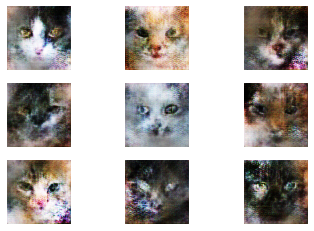

>21, 1/123, d1=0.529, d2=0.692 g=1.888
>21, 2/123, d1=0.545, d2=0.461 g=1.893
>21, 3/123, d1=0.654, d2=0.455 g=1.877
>21, 4/123, d1=0.425, d2=0.483 g=1.767
>21, 5/123, d1=0.556, d2=0.441 g=1.547
>21, 6/123, d1=0.408, d2=0.592 g=1.623
>21, 7/123, d1=0.633, d2=0.338 g=1.439
>21, 8/123, d1=0.518, d2=0.535 g=1.446
>21, 9/123, d1=0.397, d2=0.472 g=1.657
>21, 10/123, d1=0.436, d2=0.391 g=1.618
>21, 11/123, d1=0.429, d2=0.555 g=1.616
>21, 12/123, d1=0.542, d2=0.565 g=1.572
>21, 13/123, d1=0.520, d2=0.649 g=1.783
>21, 14/123, d1=0.789, d2=0.372 g=1.623
>21, 15/123, d1=0.608, d2=0.422 g=1.496
>21, 16/123, d1=0.544, d2=0.477 g=1.534
>21, 17/123, d1=0.409, d2=0.500 g=1.473
>21, 18/123, d1=0.510, d2=0.456 g=1.502
>21, 19/123, d1=0.495, d2=0.589 g=1.669
>21, 20/123, d1=0.582, d2=0.487 g=1.611
>21, 21/123, d1=0.628, d2=0.470 g=1.477
>21, 22/123, d1=0.551, d2=0.465 g=1.478
>21, 23/123, d1=0.510, d2=0.470 g=1.456
>21, 24/123, d1=0.462, d2=0.491 g=1.534
>21, 25/123, d1=0.422, d2=0.458 g=1.531
>21, 26/1

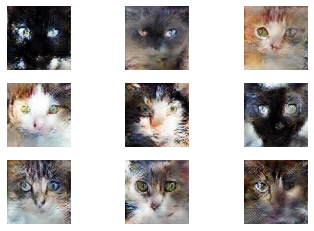

>31, 1/123, d1=0.366, d2=0.378 g=1.894
>31, 2/123, d1=0.474, d2=0.374 g=1.794
>31, 3/123, d1=0.351, d2=0.465 g=1.858
>31, 4/123, d1=0.479, d2=0.351 g=1.778
>31, 5/123, d1=0.537, d2=0.412 g=1.637
>31, 6/123, d1=0.436, d2=0.529 g=1.706
>31, 7/123, d1=0.410, d2=0.373 g=1.785
>31, 8/123, d1=0.471, d2=0.421 g=1.991
>31, 9/123, d1=0.398, d2=0.319 g=1.805
>31, 10/123, d1=0.379, d2=0.515 g=1.927
>31, 11/123, d1=0.550, d2=0.400 g=1.833
>31, 12/123, d1=0.483, d2=0.370 g=1.705
>31, 13/123, d1=0.385, d2=0.462 g=1.945
>31, 14/123, d1=0.443, d2=0.386 g=2.078
>31, 15/123, d1=0.573, d2=0.419 g=1.678
>31, 16/123, d1=0.426, d2=0.382 g=1.789
>31, 17/123, d1=0.432, d2=0.407 g=1.638
>31, 18/123, d1=0.349, d2=0.376 g=1.705
>31, 19/123, d1=0.484, d2=0.508 g=1.821
>31, 20/123, d1=0.458, d2=0.395 g=1.938
>31, 21/123, d1=0.474, d2=0.395 g=1.861
>31, 22/123, d1=0.502, d2=0.381 g=1.682
>31, 23/123, d1=0.367, d2=0.468 g=1.847
>31, 24/123, d1=0.410, d2=0.430 g=2.036
>31, 25/123, d1=0.616, d2=0.410 g=1.876
>31, 26/1

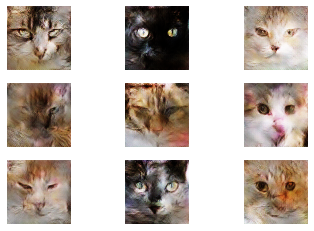

>41, 1/123, d1=0.382, d2=0.462 g=2.051
>41, 2/123, d1=0.423, d2=0.416 g=2.193
>41, 3/123, d1=0.421, d2=0.283 g=2.187
>41, 4/123, d1=0.419, d2=0.373 g=2.070
>41, 5/123, d1=0.364, d2=0.379 g=2.228
>41, 6/123, d1=0.496, d2=0.453 g=2.078
>41, 7/123, d1=0.340, d2=0.332 g=2.068
>41, 8/123, d1=0.420, d2=0.375 g=1.940
>41, 9/123, d1=0.406, d2=0.307 g=2.016
>41, 10/123, d1=0.366, d2=0.340 g=1.873
>41, 11/123, d1=0.317, d2=0.485 g=1.865
>41, 12/123, d1=0.397, d2=0.332 g=2.018
>41, 13/123, d1=0.470, d2=0.418 g=1.928
>41, 14/123, d1=0.488, d2=0.435 g=1.994
>41, 15/123, d1=0.481, d2=0.368 g=1.952
>41, 16/123, d1=0.406, d2=0.296 g=1.793
>41, 17/123, d1=0.319, d2=0.418 g=1.862
>41, 18/123, d1=0.473, d2=0.377 g=1.657
>41, 19/123, d1=0.468, d2=0.535 g=1.921
>41, 20/123, d1=0.463, d2=0.449 g=2.245
>41, 21/123, d1=0.504, d2=0.358 g=2.159
>41, 22/123, d1=0.476, d2=0.459 g=2.056
>41, 23/123, d1=0.336, d2=0.330 g=2.089
>41, 24/123, d1=0.466, d2=0.362 g=1.886
>41, 25/123, d1=0.364, d2=0.351 g=1.902
>41, 26/1

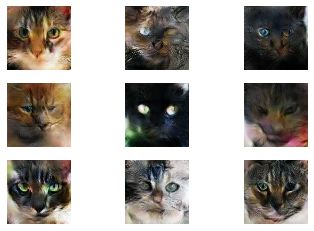

>51, 1/123, d1=0.438, d2=0.397 g=1.894
>51, 2/123, d1=0.335, d2=0.357 g=2.013
>51, 3/123, d1=0.309, d2=0.359 g=1.853
>51, 4/123, d1=0.443, d2=0.351 g=2.138
>51, 5/123, d1=0.458, d2=0.463 g=2.015
>51, 6/123, d1=0.377, d2=0.377 g=1.990
>51, 7/123, d1=0.523, d2=0.465 g=1.993
>51, 8/123, d1=0.579, d2=0.480 g=2.116
>51, 9/123, d1=0.539, d2=0.336 g=2.012
>51, 10/123, d1=0.350, d2=0.470 g=2.195
>51, 11/123, d1=0.399, d2=0.305 g=2.198
>51, 12/123, d1=0.504, d2=0.617 g=2.149
>51, 13/123, d1=0.307, d2=0.348 g=2.182
>51, 14/123, d1=0.444, d2=0.335 g=1.980
>51, 15/123, d1=0.392, d2=0.380 g=2.130
>51, 16/123, d1=0.463, d2=0.358 g=1.895
>51, 17/123, d1=0.396, d2=0.473 g=1.948
>51, 18/123, d1=0.313, d2=0.335 g=2.311
>51, 19/123, d1=0.290, d2=0.284 g=2.180
>51, 20/123, d1=0.367, d2=0.335 g=2.076
>51, 21/123, d1=0.354, d2=0.445 g=2.316
>51, 22/123, d1=0.543, d2=0.356 g=2.020
>51, 23/123, d1=0.458, d2=0.424 g=2.062
>51, 24/123, d1=0.672, d2=0.579 g=1.798
>51, 25/123, d1=0.354, d2=0.447 g=2.201
>51, 26/1

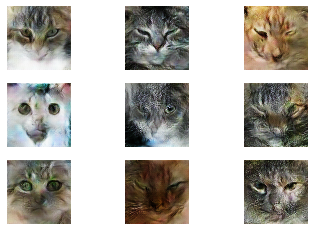

>61, 1/123, d1=0.359, d2=0.311 g=2.178
>61, 2/123, d1=0.373, d2=0.332 g=2.331
>61, 3/123, d1=0.361, d2=0.298 g=2.286
>61, 4/123, d1=0.408, d2=0.308 g=1.973
>61, 5/123, d1=0.313, d2=0.429 g=2.176
>61, 6/123, d1=0.395, d2=0.438 g=1.919
>61, 7/123, d1=0.283, d2=0.322 g=2.110
>61, 8/123, d1=0.346, d2=0.362 g=2.489
>61, 9/123, d1=0.411, d2=0.356 g=2.375
>61, 10/123, d1=0.422, d2=0.424 g=2.185
>61, 11/123, d1=0.318, d2=0.361 g=2.161
>61, 12/123, d1=0.613, d2=0.469 g=2.102
>61, 13/123, d1=0.422, d2=0.460 g=2.306
>61, 14/123, d1=0.560, d2=0.289 g=2.033
>61, 15/123, d1=0.460, d2=0.459 g=1.912
>61, 16/123, d1=0.218, d2=0.428 g=2.172
>61, 17/123, d1=0.467, d2=0.300 g=2.023
>61, 18/123, d1=0.332, d2=0.559 g=2.124
>61, 19/123, d1=0.407, d2=0.312 g=2.251
>61, 20/123, d1=0.431, d2=0.384 g=2.131
>61, 21/123, d1=0.253, d2=0.281 g=2.177
>61, 22/123, d1=0.261, d2=0.347 g=2.067
>61, 23/123, d1=0.412, d2=0.421 g=2.068
>61, 24/123, d1=0.369, d2=0.382 g=2.199
>61, 25/123, d1=0.385, d2=0.346 g=2.404
>61, 26/1

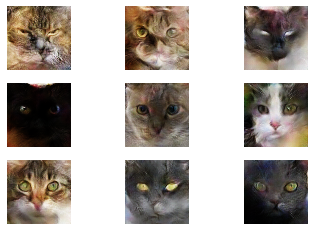

>71, 1/123, d1=0.284, d2=0.391 g=2.197
>71, 2/123, d1=0.279, d2=0.283 g=2.411
>71, 3/123, d1=0.384, d2=0.313 g=2.250
>71, 4/123, d1=0.328, d2=0.380 g=2.308
>71, 5/123, d1=0.444, d2=0.242 g=1.958
>71, 6/123, d1=0.198, d2=0.317 g=2.437
>71, 7/123, d1=0.364, d2=0.266 g=2.222
>71, 8/123, d1=0.282, d2=0.436 g=2.442
>71, 9/123, d1=0.287, d2=0.268 g=2.488
>71, 10/123, d1=0.500, d2=0.328 g=2.488
>71, 11/123, d1=0.331, d2=0.342 g=2.516
>71, 12/123, d1=0.462, d2=0.377 g=2.355
>71, 13/123, d1=0.307, d2=0.346 g=2.356
>71, 14/123, d1=0.320, d2=0.468 g=2.411
>71, 15/123, d1=0.449, d2=0.194 g=2.272
>71, 16/123, d1=0.362, d2=0.322 g=2.221
>71, 17/123, d1=0.266, d2=0.476 g=2.333
>71, 18/123, d1=0.388, d2=0.312 g=2.559
>71, 19/123, d1=0.431, d2=0.387 g=2.402
>71, 20/123, d1=0.321, d2=0.314 g=2.460
>71, 21/123, d1=0.499, d2=0.283 g=2.220
>71, 22/123, d1=0.303, d2=0.457 g=2.326
>71, 23/123, d1=0.435, d2=0.412 g=2.174
>71, 24/123, d1=0.476, d2=0.417 g=2.349
>71, 25/123, d1=0.270, d2=0.362 g=2.578
>71, 26/1

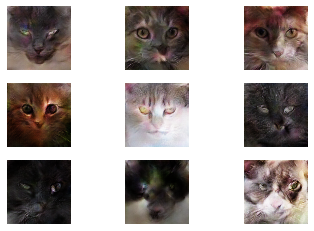

>81, 1/123, d1=0.307, d2=0.247 g=2.463
>81, 2/123, d1=0.302, d2=0.293 g=2.286
>81, 3/123, d1=0.278, d2=0.356 g=2.432
>81, 4/123, d1=0.356, d2=0.326 g=2.596
>81, 5/123, d1=0.326, d2=0.233 g=2.524
>81, 6/123, d1=0.395, d2=0.593 g=2.718
>81, 7/123, d1=0.417, d2=0.259 g=2.662
>81, 8/123, d1=0.304, d2=0.278 g=2.564
>81, 9/123, d1=0.291, d2=0.296 g=2.638
>81, 10/123, d1=0.247, d2=0.183 g=2.515
>81, 11/123, d1=0.229, d2=0.215 g=2.220
>81, 12/123, d1=0.225, d2=0.471 g=2.658
>81, 13/123, d1=0.423, d2=0.284 g=2.764
>81, 14/123, d1=0.428, d2=0.320 g=2.145
>81, 15/123, d1=0.213, d2=0.385 g=2.508
>81, 16/123, d1=0.345, d2=0.293 g=2.629
>81, 17/123, d1=0.310, d2=0.351 g=2.526
>81, 18/123, d1=0.286, d2=0.384 g=2.644
>81, 19/123, d1=0.324, d2=0.330 g=2.642
>81, 20/123, d1=0.466, d2=0.321 g=2.510
>81, 21/123, d1=0.250, d2=0.291 g=2.885
>81, 22/123, d1=0.322, d2=0.309 g=2.593
>81, 23/123, d1=0.419, d2=0.338 g=2.435
>81, 24/123, d1=0.207, d2=0.239 g=2.733
>81, 25/123, d1=0.420, d2=0.297 g=2.649
>81, 26/1

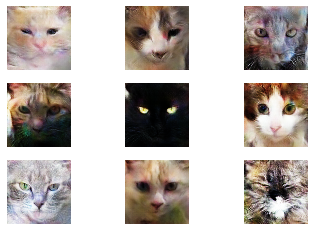

>91, 1/123, d1=0.228, d2=0.261 g=2.858
>91, 2/123, d1=0.339, d2=0.219 g=2.828
>91, 3/123, d1=0.189, d2=0.256 g=2.707
>91, 4/123, d1=0.226, d2=0.288 g=3.023
>91, 5/123, d1=0.293, d2=0.222 g=2.929
>91, 6/123, d1=0.272, d2=0.255 g=2.896
>91, 7/123, d1=0.325, d2=0.414 g=3.156
>91, 8/123, d1=0.278, d2=0.333 g=3.382
>91, 9/123, d1=0.330, d2=0.214 g=2.873
>91, 10/123, d1=0.277, d2=0.372 g=2.859
>91, 11/123, d1=0.310, d2=0.252 g=2.885
>91, 12/123, d1=0.491, d2=0.302 g=2.846
>91, 13/123, d1=0.298, d2=0.302 g=2.540
>91, 14/123, d1=0.207, d2=0.240 g=2.872
>91, 15/123, d1=0.401, d2=0.262 g=2.499
>91, 16/123, d1=0.187, d2=0.293 g=2.612
>91, 17/123, d1=0.268, d2=0.218 g=2.824
>91, 18/123, d1=0.282, d2=0.250 g=2.728
>91, 19/123, d1=0.217, d2=0.340 g=2.788
>91, 20/123, d1=0.378, d2=0.409 g=2.908
>91, 21/123, d1=0.379, d2=0.321 g=2.743
>91, 22/123, d1=0.182, d2=0.223 g=3.270
>91, 23/123, d1=0.400, d2=0.328 g=2.939
>91, 24/123, d1=0.263, d2=0.228 g=2.962
>91, 25/123, d1=0.315, d2=0.246 g=2.786
>91, 26/1

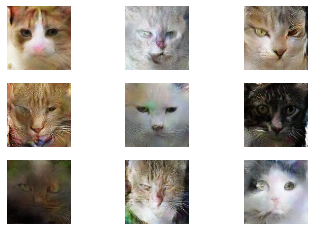

>101, 1/123, d1=0.313, d2=0.238 g=3.113
>101, 2/123, d1=0.186, d2=0.201 g=3.262
>101, 3/123, d1=0.380, d2=0.262 g=2.587
>101, 4/123, d1=0.250, d2=0.262 g=2.890
>101, 5/123, d1=0.332, d2=0.299 g=3.197
>101, 6/123, d1=0.274, d2=0.319 g=2.845
>101, 7/123, d1=0.307, d2=0.236 g=2.885
>101, 8/123, d1=0.317, d2=0.316 g=2.833
>101, 9/123, d1=0.259, d2=0.427 g=3.585
>101, 10/123, d1=0.538, d2=0.237 g=2.674
>101, 11/123, d1=0.377, d2=0.386 g=2.582
>101, 12/123, d1=0.215, d2=0.281 g=2.876
>101, 13/123, d1=0.293, d2=0.363 g=3.045
>101, 14/123, d1=0.230, d2=0.183 g=2.913
>101, 15/123, d1=0.289, d2=0.271 g=2.540
>101, 16/123, d1=0.208, d2=0.407 g=2.976
>101, 17/123, d1=0.259, d2=0.254 g=2.786
>101, 18/123, d1=0.312, d2=0.153 g=2.791
>101, 19/123, d1=0.260, d2=0.321 g=2.577
>101, 20/123, d1=0.216, d2=0.272 g=2.767
>101, 21/123, d1=0.337, d2=0.250 g=2.554
>101, 22/123, d1=0.233, d2=0.224 g=2.602
>101, 23/123, d1=0.225, d2=0.339 g=3.001
>101, 24/123, d1=0.287, d2=0.194 g=3.199
>101, 25/123, d1=0.468, d

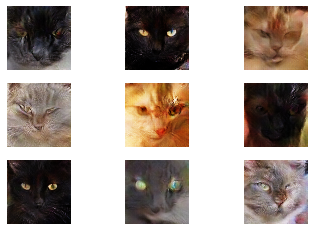

>111, 1/123, d1=0.302, d2=0.244 g=3.167
>111, 2/123, d1=0.189, d2=0.120 g=3.015
>111, 3/123, d1=0.167, d2=0.388 g=3.902
>111, 4/123, d1=0.237, d2=0.088 g=3.951
>111, 5/123, d1=0.403, d2=0.273 g=2.977
>111, 6/123, d1=0.153, d2=0.248 g=3.610
>111, 7/123, d1=0.298, d2=0.280 g=3.622
>111, 8/123, d1=0.331, d2=0.191 g=2.922
>111, 9/123, d1=0.141, d2=0.202 g=3.370
>111, 10/123, d1=0.248, d2=0.210 g=3.043
>111, 11/123, d1=0.251, d2=0.413 g=3.448
>111, 12/123, d1=0.201, d2=0.171 g=3.644
>111, 13/123, d1=0.368, d2=0.254 g=2.941
>111, 14/123, d1=0.258, d2=0.332 g=3.151
>111, 15/123, d1=0.181, d2=0.251 g=3.638
>111, 16/123, d1=0.568, d2=0.202 g=2.700
>111, 17/123, d1=0.157, d2=0.370 g=3.296
>111, 18/123, d1=0.357, d2=0.295 g=3.386
>111, 19/123, d1=0.204, d2=0.191 g=3.500
>111, 20/123, d1=0.445, d2=0.242 g=2.616
>111, 21/123, d1=0.147, d2=0.194 g=2.625
>111, 22/123, d1=0.088, d2=0.268 g=3.470
>111, 23/123, d1=0.256, d2=0.204 g=3.316
>111, 24/123, d1=0.231, d2=0.168 g=3.291
>111, 25/123, d1=0.327, d

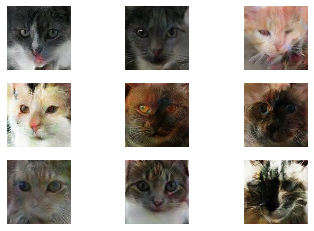

>121, 1/123, d1=0.251, d2=0.235 g=3.264
>121, 2/123, d1=0.275, d2=0.325 g=3.267
>121, 3/123, d1=0.184, d2=0.173 g=3.709
>121, 4/123, d1=0.280, d2=0.219 g=3.535
>121, 5/123, d1=0.238, d2=0.244 g=3.108
>121, 6/123, d1=0.206, d2=0.180 g=3.257
>121, 7/123, d1=0.124, d2=0.138 g=3.728
>121, 8/123, d1=0.306, d2=0.429 g=3.507
>121, 9/123, d1=0.337, d2=0.202 g=3.869
>121, 10/123, d1=0.352, d2=0.225 g=3.353
>121, 11/123, d1=0.233, d2=0.450 g=3.533
>121, 12/123, d1=0.128, d2=0.119 g=4.311
>121, 13/123, d1=0.220, d2=0.161 g=3.819
>121, 14/123, d1=0.213, d2=0.234 g=3.582
>121, 15/123, d1=0.153, d2=0.198 g=3.790
>121, 16/123, d1=0.220, d2=0.220 g=3.911
>121, 17/123, d1=0.470, d2=0.255 g=2.962
>121, 18/123, d1=0.121, d2=0.249 g=3.367
>121, 19/123, d1=0.193, d2=0.120 g=4.008
>121, 20/123, d1=0.255, d2=0.223 g=3.395
>121, 21/123, d1=0.213, d2=0.295 g=3.364
>121, 22/123, d1=0.166, d2=0.128 g=3.642
>121, 23/123, d1=0.263, d2=0.274 g=3.244
>121, 24/123, d1=0.085, d2=0.142 g=3.447
>121, 25/123, d1=0.260, d

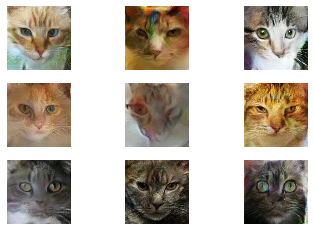

>131, 1/123, d1=0.304, d2=0.213 g=3.664
>131, 2/123, d1=0.167, d2=0.386 g=4.219
>131, 3/123, d1=0.162, d2=0.141 g=4.178
>131, 4/123, d1=0.413, d2=0.215 g=3.278
>131, 5/123, d1=0.088, d2=0.209 g=3.610
>131, 6/123, d1=0.159, d2=0.168 g=3.841
>131, 7/123, d1=0.199, d2=0.054 g=3.383
>131, 8/123, d1=0.174, d2=0.256 g=3.541
>131, 9/123, d1=0.107, d2=0.110 g=3.763
>131, 10/123, d1=0.254, d2=0.273 g=3.583
>131, 11/123, d1=0.237, d2=0.076 g=3.345
>131, 12/123, d1=0.104, d2=0.338 g=4.056
>131, 13/123, d1=0.283, d2=0.124 g=3.899
>131, 14/123, d1=0.129, d2=0.130 g=3.835
>131, 15/123, d1=0.174, d2=0.185 g=3.524
>131, 16/123, d1=0.082, d2=0.191 g=3.987
>131, 17/123, d1=0.266, d2=0.169 g=3.127
>131, 18/123, d1=0.134, d2=0.340 g=4.111
>131, 19/123, d1=0.176, d2=0.095 g=4.452
>131, 20/123, d1=0.212, d2=0.197 g=3.887
>131, 21/123, d1=0.293, d2=0.278 g=3.934
>131, 22/123, d1=0.159, d2=0.178 g=3.518
>131, 23/123, d1=0.239, d2=0.246 g=3.724
>131, 24/123, d1=0.189, d2=0.186 g=3.585
>131, 25/123, d1=0.151, d

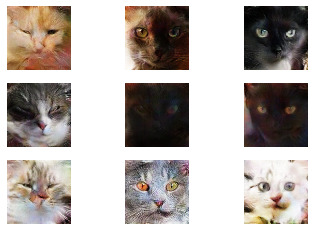

>141, 1/123, d1=0.061, d2=0.221 g=4.545
>141, 2/123, d1=0.222, d2=0.180 g=4.498
>141, 3/123, d1=0.259, d2=0.132 g=3.964
>141, 4/123, d1=0.174, d2=0.175 g=3.682
>141, 5/123, d1=0.159, d2=0.213 g=3.822
>141, 6/123, d1=0.127, d2=0.130 g=4.148
>141, 7/123, d1=0.199, d2=0.134 g=3.893
>141, 8/123, d1=0.111, d2=0.162 g=4.164
>141, 9/123, d1=0.125, d2=0.306 g=4.777
>141, 10/123, d1=0.430, d2=0.094 g=3.433
>141, 11/123, d1=0.112, d2=0.273 g=4.030
>141, 12/123, d1=0.181, d2=0.152 g=3.543
>141, 13/123, d1=0.179, d2=0.344 g=3.986
>141, 14/123, d1=0.343, d2=0.144 g=3.791
>141, 15/123, d1=0.061, d2=0.098 g=3.976
>141, 16/123, d1=0.188, d2=0.168 g=3.392
>141, 17/123, d1=0.126, d2=0.351 g=3.926
>141, 18/123, d1=0.240, d2=0.201 g=4.257
>141, 19/123, d1=0.192, d2=0.309 g=4.465
>141, 20/123, d1=0.192, d2=0.097 g=4.227
>141, 21/123, d1=0.173, d2=0.224 g=4.162
>141, 22/123, d1=0.264, d2=0.164 g=3.460
>141, 23/123, d1=0.153, d2=0.233 g=3.952
>141, 24/123, d1=0.239, d2=0.097 g=3.257
>141, 25/123, d1=0.122, d

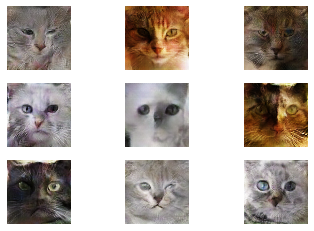

In [84]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=150, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create a goal of discriminater not detecting any fakes
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

# train model
train(g_model, d_model, gan_model, X, latent_dim)

After training the generator I then can display some samples of the images it creates.

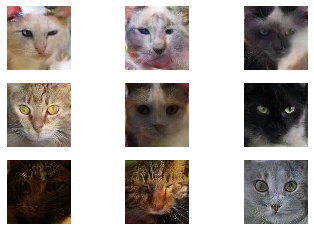

In [97]:
X, _ = generate_fake_samples(g_model, 100, 9)
display_images(X)


In addition to to the standard DCGAN architecture which uses transposed convolutions to increase an image's resolution, there is a second method that is occasionally used in the generator: upsample + convolution. This method is very similar to the previously used method, but the upsample layer is not trainable. All the upsample layer in keras does is pad the image, and it does this the same every time. Therefore, in order to add trainablility, a convolutional layer is added after the upsample with a stride of (1,1) which produces an image of the same size as was inputed into it. The upsample layer doubles the image, then the convolutional layer will learn to interpret that doubled image and translate it into meaningful detail. While the size of the output of the two methods is the same, they generally produce fairly different results. For instance, this article, https://distill.pub/2016/deconv-checkerboard/, proposes the use of upsample + convolution as an alternative to transpose convolutional layers as they can cause artifacting in an image (a known problem with DCGAN output). To test this, I switched the conv2DTranspose layers in my generator with the matching upsample + convolution layers. Then I ran the code again to train this new system with all of the same settings (besides the switched layers in the generator). This is the model structure I used:

In [0]:
# define the standalone generator model
def define_upsample_generator(latent_dim):
    model = Sequential()
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(Reshape((4, 4, 256)))
    # upsample to 8x8
    model.add(UpSampling2D()) 
    model.add(Conv2D(128, kernel_size=4, padding="same")) 
    model.add(Activation("relu")) 
    # upsample to 16x16
    model.add(UpSampling2D()) 
    model.add(Conv2D(64, kernel_size=4, padding="same")) 
    model.add(Activation("relu")) 
    # upsample to 32x32
    model.add(UpSampling2D()) 
    model.add(Conv2D(32, kernel_size=4, padding="same")) 
    model.add(Activation("relu")) 
    # upsample to 64x64
    model.add(UpSampling2D()) 
    model.add(Conv2D(32, kernel_size=4, padding="same")) 
    model.add(Activation("relu"))
    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

I could not figure out a way to simply switch out the generator of the gan model and rerun it in one jupyter notebook (my discriminator would always act like it was already trained on the real images even when I attempted to reset it and the combined gan's weights), but a copy of my DCGAN using the upsampling can be found in the code base as upsamplingConvolution.py.


## Results:
Overall, the resulting pictures from my DCGAN generator are fairly good. They display decent varience and are fairly recognizable as cats.

<img src="150gif.gif" align="center">

The generator is not always consistent though and makes mistakes. The mistakes are especially apparent in the eyes usually either through mismatched colors, having the eyes look the wrong direction, or mixing eye shapes. The images are not especially artifact heavy to me, which is something DCGANs are known to do (perhaps it would be more noticable on larger images).

The upsampling+convolution combination network did not do nearly as well, at least when using the same setting as before. The discriminator's loss gradually became lower and the image varience and quality stayed farily low. The model seems to have suffered a mix of mode collapse and vanashing gradients as it both does not display much varience in output and also began increasing in loss to an irrecoverable amount. Generally in my testing the upsampling structure seemed to perform worse than convolutional transpose, even after changing the parameters.

The difference between the two methods in practice is especially apparent in early epochs. Comparing an image generated by the DCGAN at epoch 10,

<img src="images/DCGANe10.png" /> ![](images/DCGANe10.png)

to an image generated by the upsampling GAN also at epoch 10,

<img src="images/upsample_e10.png" /> ![](images/upsample_e10.png)

reveals some of the artifacting that DCGANs can display and also the lack of it in the upsample GAN.

Using this code sample below, the outputs of the two GANs can viewed through generating from the saved model at epoch 150.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


DCGAN Pictures:


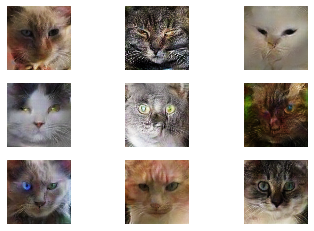

upsampleGAN Pictures:


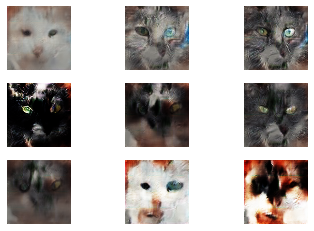

In [107]:
# generate example images
dcganPath = 'generator_model_150.h5'
upsamplePath = 'upsample_generator_model_150.h5'

dc_model = load_model(dcganPath)
upsample_model = load_model(upsamplePath)

print('DCGAN Pictures:')
X, _ = generate_fake_samples(dc_model, 100, 9)
display_images(X)
print('upsampleGAN Pictures:')
X, _ = generate_fake_samples(upsample_model, 100, 9)
display_images(X)

## Implications:
The use of GAN has many implications for the world as the quality and scalablity of networks continues to improve. A GAN's generator, in at least some form, has the ability to create something from almost nothing in a similar way to humans. This is especially apparent in applications of GAN with art work. A good enough GAN can learn to create nearly perfect new works of art in the style of any artist, and many humans would be unable to distinguish the difference with a good enough GAN. Some of my generated cat photos, for instance, were fairly indistinguishable from the real cat photos. People generally believe the photos they see are from reality. This ability to generate a forgery of reality could easily be used for evil in the world. Scammers, for instance, would benifit greatly from being able to generate forgeries of real things in mass amounts; whether that be a website, a picture, or a video. Furthermore, in the future if AIs like GANs become even better and in more varied domains, it would become nearly impossible to determine if a human had created a work, or if an AI had created it.

GAN, to me, also borders very close to the idea of an AI training itself. A strategy for training neural networks in the future might very well rely on using GANs to generate synthetic data to train with. This would bring up its own set of problems, as this would be extrapolating from a very small set of data a large one which would lead to bias in the dataset.

## Bibliography:

Brownlee, Jason. “How to Develop a GAN to Generate CIFAR10 Small Color Photographs.” Machine Learning Mastery, Machine Learning Mastery Pty, 24 July 2019, machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/.

Gupta, Alind. “Building a Generative Adversarial Network Using Keras.” GeeksforGeeks, 25 June 2019, www.geeksforgeeks.org/building-a-generative-adversarial-network-using-keras/.

Radford, Alec, Luke Metz, and Soumith Chintala. "Unsupervised representation learning with deep convolutional generative adversarial networks." arXiv preprint arXiv:1511.06434 (2015).

Odena, et al., "Deconvolution and Checkerboard Artifacts", Distill, 2016. http://doi.org/10.23915/distill.00003
